# Comparison of Gradient descent, BCGM randomized and BCGM cyclic

## Introduction

Following we will compare different gradient descent methods and BCGD methods using Gauss-Seidel scheme

The following are env variables used to control the behavior of the notebook:
 - `NUM_ITERS`: maximum number of iteration allowed to the algorithms
 - `NUM_POINTS`: number of points to generate
 - `OUTPUT_STEP`: controls the verbosity (`0.05` means _each 5% of the algorithm print update_)
 - `LABELED_PERCENTAGE`: percentage of points that are going to be labeled
 - `OPTIMIZE_RANDOM`: use the optimized version of BCGM Randomized, using Nesterov
 - `STEP_SIZE`: step size to use in case `USE_LIPSCHITZ_CONSTANT` is false
 - `EPSILON`: threshold of $||\nabla f(y)||$ to consider a solution as optimal/acceptable (in case of strong convexity, $f(x_k) - f(x^*) <= \epsilon^2/(4\sigma)$)
 - `USE_LIPSCHITZ_CONSTANT`: use Lipschitz constant for the step size (however to estimate it, it's necessary to calculate the eigenvalues of the Hessian, which for $\ge10.000$ point might take a while)
 - `OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM`: use the optimized Lipschitz constant for BCGM algorithms, calculatend on the block and not on the whole function (`USE_LIPSCHITZ_CONSTANT` must be true)
 - `INITIALIZE_RANDOM`: initialize unlabeled points in ${-1, 1}$, if `False` all points are initialized to 0
 - `PLOT_DPI`: DPI for the `matplotlib` plots
 - `FROM_DATASET`: download data from dataset
 - `Dataset`: from which dataset we want the data, available are:
   - `diabetes`: Harvard Dataverse, Ramachandran, Anil, 2018
   - `beans`: KOKLU, M. and OZKAN, I.A., (2020), Multiclass Classification of Dry Beans
   - `mnist`: MNIST digits from Sklearn (images 8x8)
   - `mnist_keras`: MNIST digits from Keras (images 28x28)
 - `CREATE_GIF`: create gif of the iterations

In [926]:
NUM_ITERS = 60
NUM_POINTS = 10000
OUTPUT_STEP = 0.1
LABELED_PERCENTAGE = 0.1
OPTIMIZE_RANDOM = False
STEP_SIZE = 1e-4
EPSILON = 1e-5
USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
INITIALIZE_RANDOM = True
PLOT_DPI=100
FROM_DATASET = False
DATASET = "mnist_keras"
CREATE_GIF = True

In [927]:
import math
import matplotlib.pyplot as pl
import random
import numpy as np
import scipy.linalg
import time
from sklearn.metrics.pairwise import euclidean_distances
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits
from tensorflow import keras
import pandas as pd
from io import StringIO
import os
import imageio
from os import walk
import shutil

Setting seed in order to have reproducible results

In [928]:
random.seed(1)
np.random.seed(1)

In [929]:
def delete_files_in_folder(dirpath):
    filepath = ""
    for filename in os.listdir(dirpath):
        filepath = os.path.join(dirpath, filename)
    if filepath:
        try:
            shutil.rmtree(filepath)
        except OSError:
            os.remove(filepath)

def create_frame(i, x_unlabeled, y_unlabeled, path, title="Plot"):
    final_y_unlabeled = (y_unlabeled/2 + .5).round() * 2 - 1
    fig = pl.figure(dpi=PLOT_DPI)
    pl.title(f"{title} - iteration {i}")
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])
    pl.plot()
    pl.savefig(f'{path}frame-{i:05}.png')
    pl.close(fig)

def check_or_create(path):
    exist = os.path.exists(path)
    if not exist:
        os.makedirs(path)

if CREATE_GIF:
    check_or_create("./gif")
    paths =[
        "./gif/gd",
        "./gif/gd_improved",
        "./gif/gd_hb",
        "./gif/gd_accelerated",
        "./gif/bcgd_random",
        "./gif/bcgd_cyclic",
        "./gif/bcgd_gs"
    ]
    for path in paths:
        check_or_create(path)
        delete_files_in_folder(path)



### Generating points

Depending if `FROM_DATASET` is `True`, the dataset elements will be decomposed using PCA, since the model is very sensible to curse of dimensionality.

In [930]:
if FROM_DATASET and DATASET == "diabetes":
    CLASS_0 = "https://drive.google.com/uc?export=download&id=1GAsdQfu3VfIE9HdjMmNssD0LUpNZC9oq"

    CLASS_1 = "https://drive.google.com/uc?export=download&id=1wDnGDGAgzGV_20AocaW4icCpgtP2vZzZ"

    print("""
    Downloading dataset:
    Ramachandran, Anil, 2018, "class0_diabetes.txt", Binary dataset, https://doi.org/10.7910/DVN/LRNLZV/ZIOATY, Harvard Dataverse, V1
    """)
    r0 = [[float(s) for s in row.split('\t')][:-1]
          for row in requests.get(CLASS_0, allow_redirects=True).content.decode("utf-8").replace("\r", "").split("\n")[:-1]]
    tuples_0 = np.array(r0).astype('float64')
    print("""
    Downloading dataset:
    Ramachandran, Anil, 2018, "class1_diabetes.txt", Binary dataset, https://doi.org/10.7910/DVN/LRNLZV/0KQIC4, Harvard Dataverse, V1
    """)
    r1 = [[float(s) for s in row.split('\t')][:-1]
          for row in requests.get(CLASS_1, allow_redirects=True).content.decode("utf-8").replace("\r", "").split("\n")[:-1]]
    tuples_1 = np.array(r1).astype('float64')

    pca = PCA(n_components=2).fit(np.concatenate((tuples_0, tuples_1)))
    tuples_0 = pca.transform(tuples_0)
    tuples_1 = pca.transform(tuples_1)

    points = min(len(tuples_0), len(tuples_1), NUM_POINTS)
    tuples_0 = tuples_0[:points]
    tuples_1 = tuples_1[:points]
    print("Done")
elif FROM_DATASET and DATASET == "mnist":
    print("Loading mnist digits 8x8")
    digits = load_digits()
    X = digits.data
    Y = digits.target
    pca = PCA(n_components=5)
    X = pca.fit_transform(X)
    points = min(np.sum(Y == 0), np.sum(Y != 0), NUM_POINTS)
    tuples_0 = X[Y == 0][:points]
    tuples_1 = X[Y != 0][:points]
    print("Done")
elif FROM_DATASET and DATASET == "mnist_keras":
    print("Loading mnist digits 28x28")
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    X = np.concatenate((x_train, x_test))
    Y = np.concatenate((y_train, y_test))
    X = X.reshape((X.shape[0], -1))
    pca = PCA(n_components=5)
    X = pca.fit_transform(X)
    points = min(np.sum(Y == 0), np.sum(Y != 0), NUM_POINTS)
    tuples_0 = X[Y == 0][:points]
    tuples_1 = X[Y != 0][:points]
    print("Done")
elif FROM_DATASET and DATASET == "beans":
    print("""
    Downloading dataset:
    KOKLU, M. and OZKAN, I.A., (2020), Multiclass Classification of Dry Beans Using Computer Vision and Machine Learning Techniques. Computers and Electronics in Agriculture, 174, 105507.
    """)
    URL = "https://drive.google.com/uc?export=download&id=1UOrXMy6uKDhnwS9fAyFmSjtpxFkyh8Zg"
    # we are just going to use "SIRA" (2636 samples) vs "DERMASON" (3546 samples)
    data_raw = StringIO(requests.get(URL, allow_redirects=True).content.decode("utf-8"))
    df = pd.read_csv(data_raw, delimiter=";", header=None)
    target = df[16].to_numpy()
    data = df.drop(16, axis=1).to_numpy(dtype="float64")
    pca = PCA(n_components=5)
    data = pca.fit_transform(data)
    points = min(np.sum(target == "SIRA"), np.sum(target == "DERMASON"), NUM_POINTS)
    tuples_0 = data[target == "SIRA"][:points]
    tuples_1 = data[target != "DERMASON"][:points]
    print("Done")

In [931]:
"""gen1 = lambda x : -pow(x-.45, 5) * 20 + 0.8
gen2 = lambda x : -pow(x-.3, 2) * 5 + 0.4
range1 = (0, 1)
range2 = (0, 1)"""

"""gen1 = lambda x : math.e**(-x+2)+1
gen2 = lambda x : -math.e**(x-5)+6
range1 = (1, 6)
range2 = (1, 6)"""


"""gen1 = lambda x: ((2*x-1.5) ** 3 + (2*x-1.5) ** 2 + 0.3)/2
gen2 = lambda x: x**2/5 + 0.5
range1 = (0, 1)
range2 = (0, 1)"""

gen1 = lambda x : x
gen2 = lambda x : -x
range1 = (-1, 1)
range2 = (-1, 1)



Generating points
done
Generating variances
Done


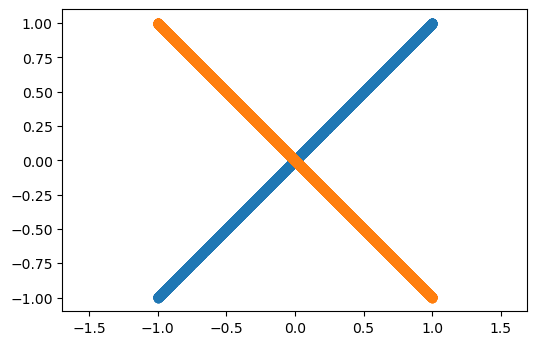

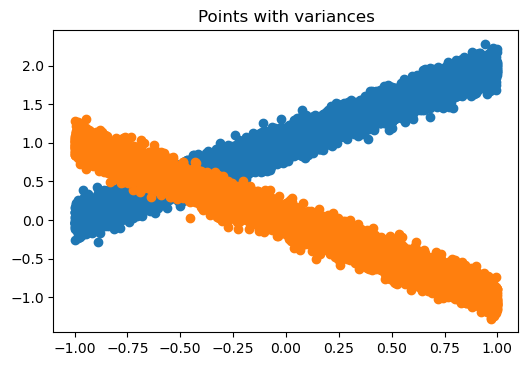

In [932]:
if not FROM_DATASET:
    print("Generating points")
    x0 = np.random.uniform(*range1, NUM_POINTS)
    x1 = np.random.uniform(*range2, NUM_POINTS)

    f_x0 = gen1(x0)
    f_x1 = gen2(x1)
    print("done")

    pl.figure(dpi=PLOT_DPI)
    pl.axis('equal')
    pl.scatter(x0, f_x0)
    pl.scatter(x1, f_x1)

    print("Generating variances")
    rand_var_0 = np.random.normal(1, 0.1, len(x0))
    rand_var_1 = np.random.normal(0, 0.1, len(x1))

    f_x0_final = f_x0 + rand_var_0
    f_x1_final = f_x1 + rand_var_1
    print("Done")

    pl.figure(dpi=PLOT_DPI)
    pl.axis('auto')
    pl.title("Points without variances")
    pl.scatter(x0, f_x0_final)
    pl.title("Points with variances")
    pl.scatter(x1, f_x1_final)

    tuples_0 = np.array(list(zip(x0, f_x0_final)))
    tuples_1 = np.array(list(zip(x1, f_x1_final)))


In [933]:
print("Splitting points in labeled and unlabeled")
print(f"{len(tuples_0)} elements class -1 and {len(tuples_1)} elements class 1")
scaler = pipe = Pipeline([('mm_scaler', MinMaxScaler()),('std_scaler', StandardScaler())]).fit(np.concatenate((tuples_0, tuples_1)))
# unlabeled examples of class -1
x_0 = scaler.transform(tuples_0[int(len(tuples_0) * LABELED_PERCENTAGE):])
# labeled examples of class -1
x_bar_0 = scaler.transform(tuples_0[:int(len(tuples_0) * LABELED_PERCENTAGE)])
# label for unlabeled examples of class -1
y_0 = np.repeat(-1, len(x_0)).astype('float64')
# label for labeled examples of class -1
y_bar_0 = np.repeat(-1, len(x_bar_0)).astype('float64')

# unlabeled examples of class 1
x_1 = scaler.transform(tuples_1[int(len(tuples_1) * LABELED_PERCENTAGE):])
# labeled examples of class 1
x_bar_1 = scaler.transform(tuples_1[:int(len(tuples_1) * LABELED_PERCENTAGE)])
# label for unlabeled examples of class 1
y_1 = np.repeat(1, len(x_1)).astype('float64')
# label for labeled examples of class 1
y_bar_1 = np.repeat(1, len(x_bar_1)).astype('float64')

x_unlabeled = np.concatenate((x_0, x_1))
x_labeled = np.concatenate((x_bar_0, x_bar_1))
y_labeled = np.concatenate((y_bar_0, y_bar_1))
y_unlabeled_target = np.concatenate((y_0, y_1))

# we need to optimize this one
y_unlabeled_initial = np.random.choice([-1, 1], size=(len(x_unlabeled),)) \
    if INITIALIZE_RANDOM else np.array([0], dtype='float64').repeat(len(x_unlabeled))
print(f"{len(x_labeled)} elements labeled and {len(x_unlabeled)} elements unlabeled")
print("Done")

Splitting points in labeled and unlabeled
10000 elements class -1 and 10000 elements class 1
2000 elements labeled and 18000 elements unlabeled
Done


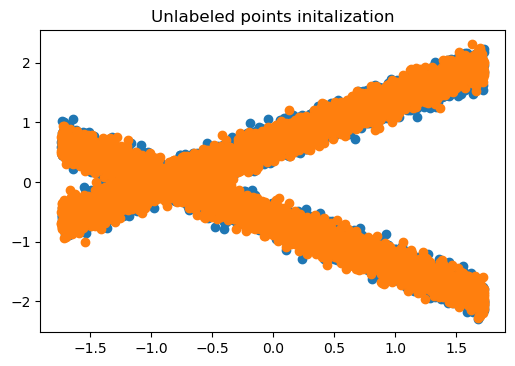

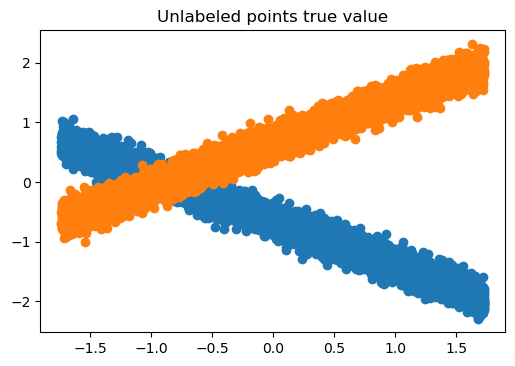

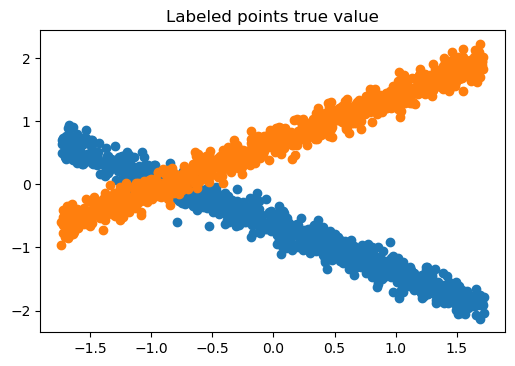

In [934]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    if INITIALIZE_RANDOM:
        pl.figure(dpi=PLOT_DPI)
        pl.title("Unlabeled points initalization")
        pl.scatter([p[0] for p in x_unlabeled[y_unlabeled_initial == 1]], [p[1] for p in x_unlabeled[y_unlabeled_initial == 1]])
        pl.scatter([p[0] for p in x_unlabeled[y_unlabeled_initial== -1]], [p[1] for p in x_unlabeled[y_unlabeled_initial == -1]])
        pl.show()

    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points true value")
    pl.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]])
    pl.scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]])
    pl.show()


    pl.figure(dpi=PLOT_DPI)
    pl.title("Labeled points true value")
    pl.scatter([p[0] for p in x_labeled[y_labeled == 1]], [p[1] for p in x_labeled[y_labeled == 1]])
    pl.scatter([p[0] for p in x_labeled[y_labeled == -1]], [p[1] for p in x_labeled[y_labeled == -1]])
    pl.show()

### Calculating weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [935]:
def weight(dist):
    return math.e**(-10* dist**2)

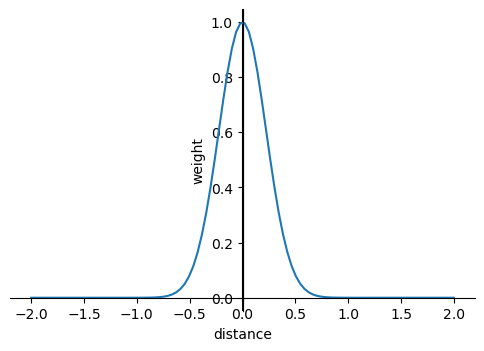

In [936]:
X = np.linspace(-2, 2, 100)
pl.figure(dpi=PLOT_DPI)
ax = pl.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")


In [937]:
%%time
def weights_labeled_unlabeled_iterative():
    labeled_unlabeled = np.zeros((len(x_labeled), len(x_unlabeled))).astype('float64')
    for i in range(len(x_unlabeled)):
        if i % (len(x_unlabeled) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(x_unlabeled)*100):02}%")
        for j in range(len(x_labeled)):
            labeled_unlabeled[j][i] = weight(np.linalg.norm(x_unlabeled[i] - x_labeled[j]))
    return labeled_unlabeled

def weights_labeled_unlabeled():
    labeled_unlabeled = euclidean_distances(x_labeled, x_unlabeled) / x_labeled.shape[1]
    return weight(labeled_unlabeled)
print("Calculating weights between labeled points and unlabeled points")
w_labeled_unlabeled = weights_labeled_unlabeled()
print("Done")

Calculating weights between labeled points and unlabeled points
Done
CPU times: user 969 ms, sys: 2.13 s, total: 3.1 s
Wall time: 554 ms


In [938]:
%%time
def weights_unlabeled_unlabeled_iterative():
    unlabeled_unlabeled = np.zeros((len(x_unlabeled), len(x_unlabeled))).astype('float64')
    for i in range(len(x_unlabeled)):
        if i % (len(x_unlabeled) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(x_unlabeled)*100):02}%")
        for j in range(len(x_unlabeled)):
            unlabeled_unlabeled[j][i] = weight(np.linalg.norm(x_unlabeled[i] - x_unlabeled[j]))
    return unlabeled_unlabeled
def weights_unlabeled_unlabeled():
    unlabeled_unlabeled = euclidean_distances(x_unlabeled, x_unlabeled) / x_unlabeled.shape[1]
    return weight(unlabeled_unlabeled)

print("Calculating weights between unlabeled points and unlabeled points")
w_unlabeled_unlabeled = weights_unlabeled_unlabeled()
print("Done")

Calculating weights between unlabeled points and unlabeled points
Done
CPU times: user 4.96 s, sys: 2.84 s, total: 7.79 s
Wall time: 5.07 s


The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the fist one is the iterative and naive implementation, the second one is using linear algebra and Numpy to calcolate it, in order to have decent performance

### Loss and Accuracy

In [939]:
def loss_iterative(labeled, unlabeled):
    global w_labeled_unlabeled, w_unlabeled_unlabeled
    tot1 = tot2 = 0.0
    for i in range(len(labeled)):
        for j in range(len(unlabeled)):
            tot1 += w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])**2
    for i in range(len(unlabeled)):
        for j in range(len(unlabeled)):
            tot2 += w_unlabeled_unlabeled[i][j] * (unlabeled[i] - unlabeled[j])**2
    return tot1 + tot2/2

def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * w_labeled_unlabeled.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * w_unlabeled_unlabeled.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [940]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)
max_loss = np.sum(w_labeled_unlabeled) * 4 + np.sum(w_unlabeled_unlabeled) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=2)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=2)
    return 1 - current_distance / initial_distance

def accuracy(current):
    return accuracy_round(current) #loss(y_labeled, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$

### Hessian and constants

In [941]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]) - w_unlabeled_unlabeled[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 483.2867992920348,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 5412.661858627785
Estimating Lipschitz constant for each single variable
Done
CPU times: user 38min 29s, sys: 1min 49s, total: 40min 18s
Wall time: 5min 4s


Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [942]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(w_labeled_unlabeled, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(w_unlabeled_unlabeled, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    y_labeled.reshape((-1,1)),
    w_labeled_unlabeled
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [943]:
def gradient_semi_iterative(labeled, unlabeled):
    grad = np.array([], dtype=float)
    for j in range(len(unlabeled)):
        tot_labeled_unlabeled = np.sum((unlabeled[j] - labeled) * w_labeled_unlabeled.T[j])
        tot_unlabeled_unlabeled = np.sum((unlabeled[j] - unlabeled) * w_unlabeled_unlabeled.T[j])
        grad = np.append(grad, tot_labeled_unlabeled * 2 + tot_unlabeled_unlabeled)
    return grad

def gradient_iterative(labeled, unlabeled):
    grads = []
    for j in range(len(unlabeled)):
        grad = 0
        for i in range(len(labeled)):
            grad += 2 * w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
        for i in range(len(unlabeled)):
            grad += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
        grads.append(grad)
    return np.array(grads)

def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        w_unlabeled_unlabeled
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [944]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [945]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if CREATE_GIF:
        create_frame(i, x_unlabeled, y_unlabeled_gd, "./gif/gd/", "Gradient Descent")

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")

00% - iter 0 / 60 - final accuracy 50.68% - loss 13152306.95
10% - iter 6 / 60 - final accuracy 93.43% - loss 3860800.91
20% - iter 12 / 60 - final accuracy 93.70% - loss 3640211.46
30% - iter 18 / 60 - final accuracy 93.77% - loss 3601409.67
40% - iter 24 / 60 - final accuracy 93.80% - loss 3601104.60
50% - iter 30 / 60 - final accuracy 93.81% - loss 3607581.37
60% - iter 36 / 60 - final accuracy 93.80% - loss 3613328.61
70% - iter 42 / 60 - final accuracy 93.80% - loss 3617226.67
80% - iter 48 / 60 - final accuracy 93.80% - loss 3619628.18
90% - iter 54 / 60 - final accuracy 93.80% - loss 3621043.89

Final accuracy: 93.8%
Norm gradient: 119.11547117833778
Loss: 3621753.6344904285

CPU times: user 5min 52s, sys: 1min 10s, total: 7min 3s
Wall time: 6min 32s


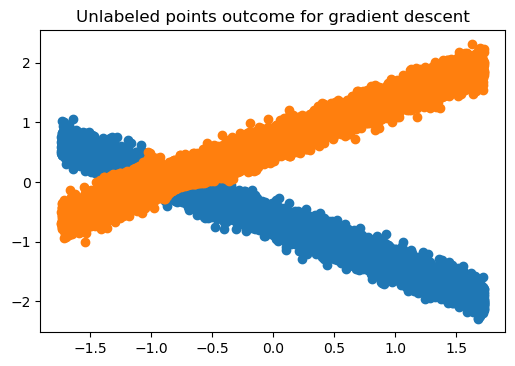

In [946]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for gradient descent")
    final_y_unlabeled = (y_unlabeled_gd/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

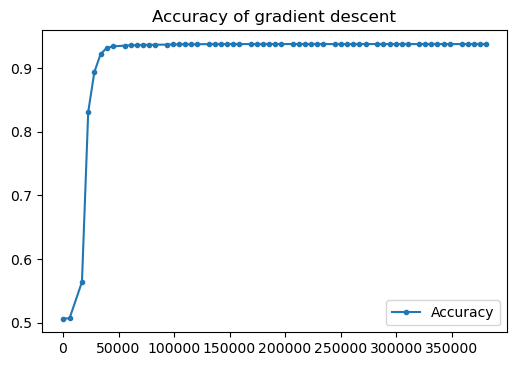

In [947]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of gradient descent")
pl.plot(ticks_gd, accuracies_gd, marker='.')
pl.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm withh use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [948]:
y_unlabeled_gd_improved = np.copy(y_unlabeled_initial)

In [949]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(y_labeled, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(y_labeled, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if CREATE_GIF:
        create_frame(i, x_unlabeled, y_unlabeled_gd_improved, "./gif/gd_improved/", "Gradient Descent Improved Rate")

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(y_labeled, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 60 - final accuracy 71.72% - loss 14370407.47
10% - iter 6 / 60 - final accuracy 92.14% - loss 3997388.96
20% - iter 12 / 60 - final accuracy 93.17% - loss 3628493.39
30% - iter 18 / 60 - final accuracy 93.56% - loss 3615252.74
40% - iter 24 / 60 - final accuracy 93.79% - loss 3619507.72
50% - iter 30 / 60 - final accuracy 93.81% - loss 3621709.65
60% - iter 36 / 60 - final accuracy 93.79% - loss 3622515.71
70% - iter 42 / 60 - final accuracy 93.79% - loss 3622790.18
80% - iter 48 / 60 - final accuracy 93.79% - loss 3622881.79
90% - iter 54 / 60 - final accuracy 93.79% - loss 3622912.19

Final accuracy: 93.79%
Norm gradient: 1.5766438578251531
Loss: 3622921.2453938704

CPU times: user 5min 50s, sys: 1min 8s, total: 6min 59s
Wall time: 6min 27s


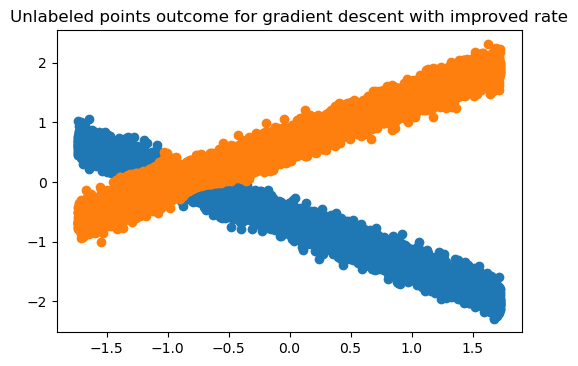

In [950]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for gradient descent with improved rate")
    final_y_unlabeled = (y_unlabeled_gd_improved/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

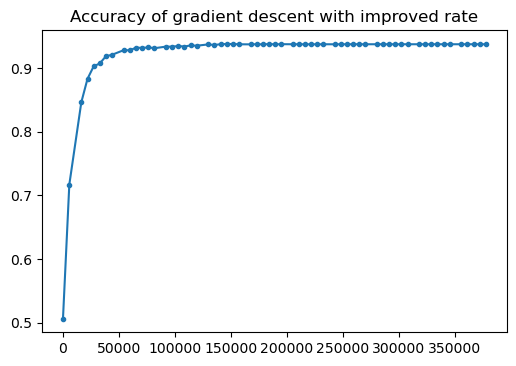

In [951]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of gradient descent with improved rate")
pl.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Heavy ball

In [952]:
y_unlabeled_gd_hb_previous = y_unlabeled_gd_hb = np.copy(y_unlabeled_initial)

In [953]:
%%time
ticks_gd_hb = [0]
accuracies_gd_hb = [accuracy(y_unlabeled_gd_hb)]
losses_gd_hb = [loss(y_labeled, y_unlabeled_gd_hb)]
init_time = time.time() * 1000
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_hb)
    if EPSILON >= np.linalg.norm(grad):
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_gd_hb - y_unlabeled_gd_hb_previous)

    old_y_unlabeled_gd_hb = np.copy(y_unlabeled_gd_hb)
    y_unlabeled_gd_hb = y_unlabeled_gd_hb - 1/L * grad + momentum
    y_unlabeled_gd_hb_previous = old_y_unlabeled_gd_hb

    accuracies_gd_hb.append(accuracy(y_unlabeled_gd_hb))
    losses_gd_hb.append(loss(y_labeled, y_unlabeled_gd_hb))
    ticks_gd_hb.append(time.time() * 1000 - init_time)

    if CREATE_GIF:
        create_frame(i, x_unlabeled, y_unlabeled_gd_hb, "./gif/gd_hb/", "Heavy Ball")

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_hb[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_hb):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_hb[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_hb))}
Loss: {loss(y_labeled, y_unlabeled_gd_hb)}
""")

00% - iter 0 / 60 - final accuracy 50.68% - loss 13152306.95
10% - iter 6 / 60 - final accuracy 90.98% - loss 3850584.51
20% - iter 12 / 60 - final accuracy 92.28% - loss 3762162.89
30% - iter 18 / 60 - final accuracy 92.82% - loss 3642839.50
40% - iter 24 / 60 - final accuracy 93.29% - loss 3623991.06
50% - iter 30 / 60 - final accuracy 93.60% - loss 3633565.26
60% - iter 36 / 60 - final accuracy 93.73% - loss 3641146.91
70% - iter 42 / 60 - final accuracy 93.76% - loss 3614525.39
80% - iter 48 / 60 - final accuracy 93.83% - loss 3623557.36
90% - iter 54 / 60 - final accuracy 93.79% - loss 3632956.99

Final accuracy: 93.69%
Norm gradient: 1768.3637530515061
Loss: 3622116.9389348

CPU times: user 5min 51s, sys: 1min 7s, total: 6min 58s
Wall time: 6min 26s


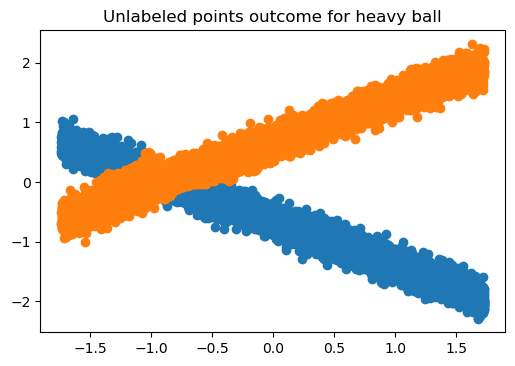

In [954]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for heavy ball")
    final_y_unlabeled = (y_unlabeled_gd_hb/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

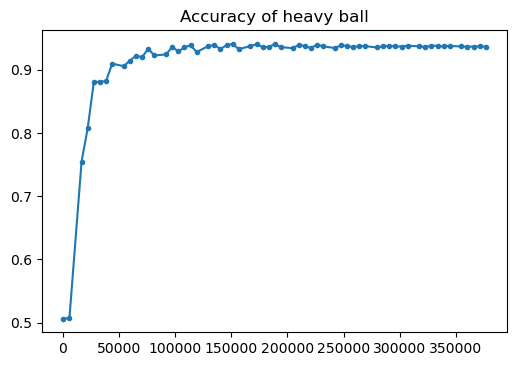

In [955]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of heavy ball")
pl.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')

### Accelerated Gradient

In [956]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(y_unlabeled_initial)

In [957]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(y_labeled, y_unlabeled_gd_accelerated)]
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)
    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated

    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(y_labeled, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)

    if CREATE_GIF:
        create_frame(i, x_unlabeled, y_unlabeled_gd_accelerated, "./gif/gd_accelerated/", "Accelerated Gradient")

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(y_labeled, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 60 - final accuracy 50.68% - loss 13152306.95
10% - iter 6 / 60 - final accuracy 93.83% - loss 3642969.21
20% - iter 12 / 60 - final accuracy 93.79% - loss 3659455.42
30% - iter 18 / 60 - final accuracy 93.75% - loss 3631168.31
40% - iter 24 / 60 - final accuracy 93.79% - loss 3616100.28
50% - iter 30 / 60 - final accuracy 93.79% - loss 3622587.45
60% - iter 36 / 60 - final accuracy 93.79% - loss 3625873.22
70% - iter 42 / 60 - final accuracy 93.79% - loss 3622055.74
80% - iter 48 / 60 - final accuracy 93.79% - loss 3622165.92
90% - iter 54 / 60 - final accuracy 93.79% - loss 3623547.01

Final accuracy: 93.8%
Norm gradient: 24.695201913771882
Loss: 3623166.3099342003

CPU times: user 5min 50s, sys: 1min 8s, total: 6min 59s
Wall time: 6min 27s


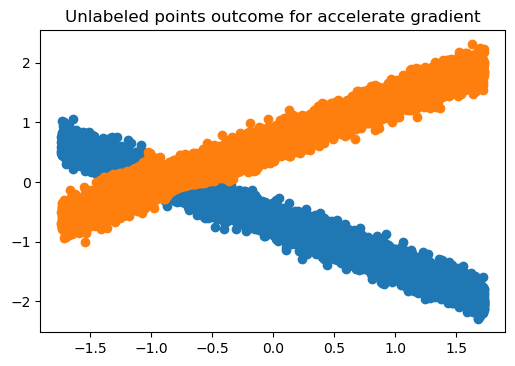

In [958]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for accelerate gradient")
    final_y_unlabeled = (y_unlabeled_gd_accelerated/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

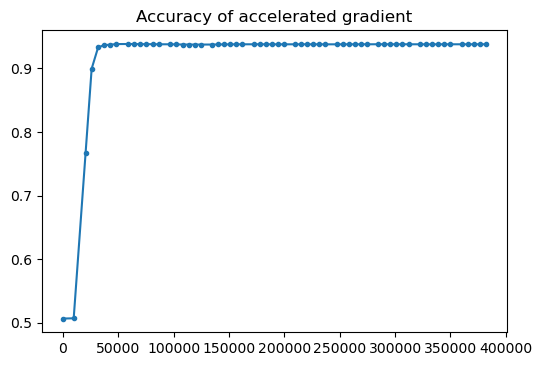

In [959]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of accelerated gradient")
pl.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [960]:
def derivative(unlabeled, j):
    return grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T)

def derivative_iterative(labeled, unlabeled, j):
    tot = 0
    for i in range(len(labeled)):
        tot += 2*w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
    for i in range(len(unlabeled)):
        tot += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
    return tot

def update_gradient(previous_grad, Li, index):
    global w_unlabeled_unlabeled, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += w_unlabeled_unlabeled[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [961]:
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [962]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(y_labeled, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.choice(len(y_unlabeled_bcgd_random), max_iterations, p=optimized_sampling_probabilities)[0] \
    if OPTIMIZE_RANDOM else np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        if CREATE_GIF:
            create_frame(i // len(y_unlabeled_target),x_unlabeled, y_unlabeled_bcgd_random, "./gif/bcgd_random/", "BCGD Random")

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(y_labeled, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 1080000 - final accuracy 50.64% - loss 57674167.36
10% - iter 108000 / 1080000 - final accuracy 90.38% - loss 4491992.36
20% - iter 216000 / 1080000 - final accuracy 93.54% - loss 3704531.95
30% - iter 324000 / 1080000 - final accuracy 93.71% - loss 3614342.64
40% - iter 432000 / 1080000 - final accuracy 93.78% - loss 3602006.55
50% - iter 540000 / 1080000 - final accuracy 93.78% - loss 3605487.36
60% - iter 648000 / 1080000 - final accuracy 93.79% - loss 3611093.68
70% - iter 756000 / 1080000 - final accuracy 93.79% - loss 3615515.74
80% - iter 864000 / 1080000 - final accuracy 93.80% - loss 3618460.57
90% - iter 972000 / 1080000 - final accuracy 93.80% - loss 3620287.97

Final accuracy: 93.8%
Norm gradient: 183.01149284827233
Loss: 3621384.448783333

CPU times: user 6min 8s, sys: 57.2 s, total: 7min 5s
Wall time: 6min 33s


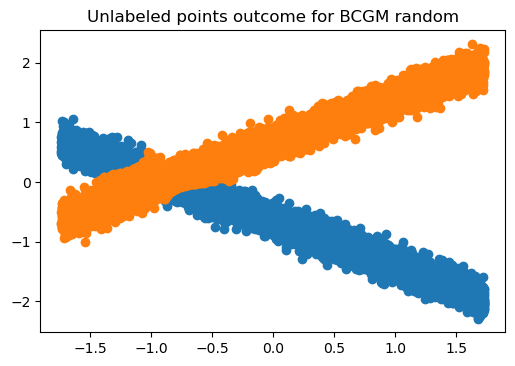

In [963]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM random")
    final_y_unlabeled = (y_unlabeled_bcgd_random/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

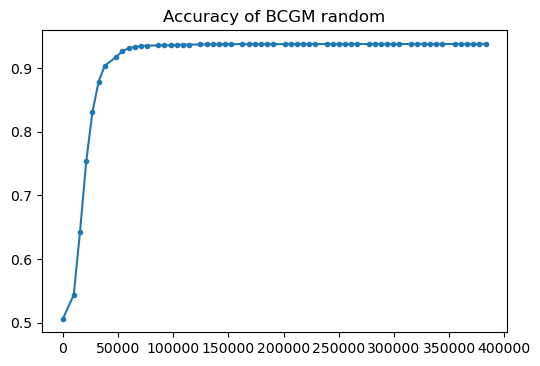

In [964]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM random")
pl.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Cyclic

In [965]:
y_unlabeled_bcgd_cyclic = np.copy(y_unlabeled_initial).astype("float64")

In [966]:
%%time
ticks_bcgd_cyclic= [0]
accuracies_bcgd_cyclic= [accuracy(y_unlabeled_bcgd_cyclic)]
losses_bcgm_cyclic = [loss(y_labeled, y_unlabeled_bcgd_cyclic)]

previous_grad_cyclic = gradient(y_unlabeled_bcgd_cyclic)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_cyclic)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = i % len(y_unlabeled_bcgd_cyclic)

    step, new_grad = update_gradient(previous_grad_cyclic, Li, index)
    y_unlabeled_bcgd_cyclic[index] = y_unlabeled_bcgd_cyclic[index] - step
    previous_grad_cyclic = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_cyclic):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        if CREATE_GIF:
            create_frame(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_cyclic, "./gif/bcgd_cyclic/", "BCGD Cyclic")

        accuracies_bcgd_cyclic.append(accuracy(y_unlabeled_bcgd_cyclic))
        losses_bcgm_cyclic.append(loss(y_labeled, y_unlabeled_bcgd_cyclic))
        ticks_bcgd_cyclic.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_cyclic[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_cyclic):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_cyclic[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_cyclic))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_cyclic)}
""")

00% - iter 0 / 1080000 - final accuracy 50.64% - loss 57673408.59
10% - iter 108000 / 1080000 - final accuracy 93.11% - loss 3867855.69
20% - iter 216000 / 1080000 - final accuracy 93.62% - loss 3626269.89
30% - iter 324000 / 1080000 - final accuracy 93.74% - loss 3602134.85
40% - iter 432000 / 1080000 - final accuracy 93.78% - loss 3607036.90
50% - iter 540000 / 1080000 - final accuracy 93.79% - loss 3613601.49
60% - iter 648000 / 1080000 - final accuracy 93.79% - loss 3617916.95
70% - iter 756000 / 1080000 - final accuracy 93.80% - loss 3620334.59
80% - iter 864000 / 1080000 - final accuracy 93.80% - loss 3621608.69
90% - iter 972000 / 1080000 - final accuracy 93.80% - loss 3622262.18

Final accuracy: 93.79%
Norm gradient: 36.81561229410355
Loss: 3622593.1134570884

CPU times: user 6min 10s, sys: 59.6 s, total: 7min 10s
Wall time: 6min 38s


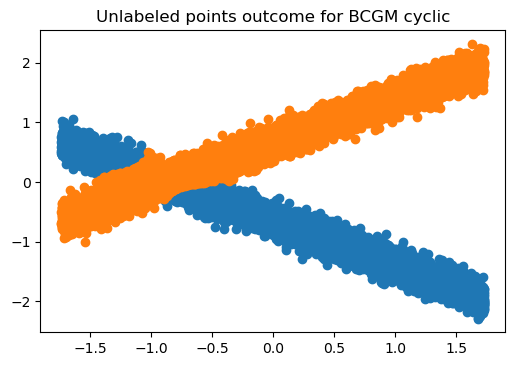

In [967]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM cyclic")
    final_y_unlabeled = (y_unlabeled_bcgd_cyclic/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

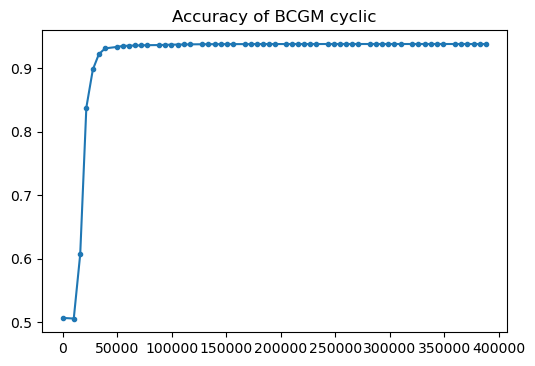

In [968]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM cyclic")
pl.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')

### Gauss-Southwell

In [969]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [970]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        if CREATE_GIF:
            create_frame(i // len(y_unlabeled_target), x_unlabeled, y_unlabeled_bcgd_gs, "./gif/bcgd_gs/", "BCGD Gauss-Southwell")

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 1080000 - final accuracy 50.64% - loss 57672676.81
10% - iter 108000 / 1080000 - final accuracy 91.90% - loss 3628591.52
20% - iter 216000 / 1080000 - final accuracy 93.55% - loss 3622987.31
30% - iter 324000 / 1080000 - final accuracy 93.74% - loss 3622938.63
40% - iter 432000 / 1080000 - final accuracy 93.78% - loss 3622929.74
50% - iter 540000 / 1080000 - final accuracy 93.80% - loss 3622927.93
60% - iter 648000 / 1080000 - final accuracy 93.80% - loss 3622927.44
70% - iter 756000 / 1080000 - final accuracy 93.79% - loss 3622927.31
80% - iter 864000 / 1080000 - final accuracy 93.79% - loss 3622927.26
90% - iter 972000 / 1080000 - final accuracy 93.79% - loss 3622927.24

Final accuracy: 93.79%
Norm gradient: 0.02329864986919395
Loss: 3622927.238313416

CPU times: user 6min 22s, sys: 1min, total: 7min 23s
Wall time: 6min 51s


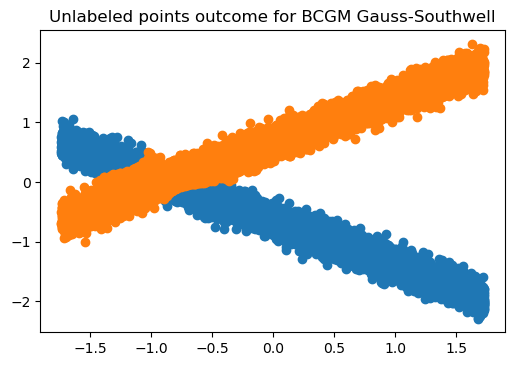

In [971]:
if not FROM_DATASET or x_labeled.shape[1] == 2:
    pl.figure(dpi=PLOT_DPI)
    pl.title("Unlabeled points outcome for BCGM Gauss-Southwell")
    final_y_unlabeled = (y_unlabeled_bcgd_gs/2 + .5).round() * 2 - 1
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == 1]], [p[1] for p in x_unlabeled[final_y_unlabeled == 1]])
    pl.scatter([p[0] for p in x_unlabeled[final_y_unlabeled == -1]], [p[1] for p in x_unlabeled[final_y_unlabeled == -1]])

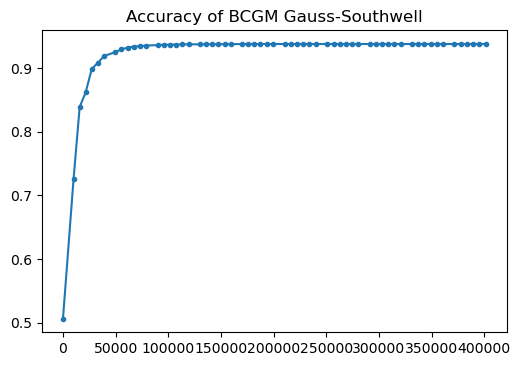

In [972]:
pl.figure(dpi=PLOT_DPI)
pl.title("Accuracy of BCGM Gauss-Southwell")
pl.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

## Comparison

As we can see, the BCGM cyclic is the fastest, since using the Lipschitz constant for the single bloc, after one iteration (considered as one complete cycle over all the blocks) finds the best solution, followed by the BCGM random, which also exploits the Lipschitz fo the singe variable to have a better estimate of the stepsize.
In last position we find the Gradient Descent, which is slower due to the stepsize estimated using the Lipschitz constant of the whole problem, which is the highest eigenvalue, and therefore is just a "safe" upper bound

### All algorithms compared

In [973]:
min_acc = np.min(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs, accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs, accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

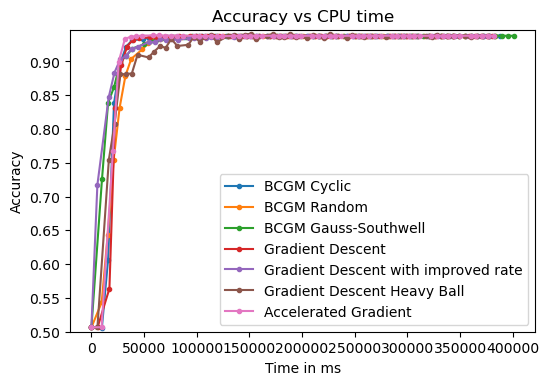

In [974]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')
pl.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')
pl.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')
pl.plot(ticks_gd, accuracies_gd, marker='.')
pl.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')
pl.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

pl.title("Accuracy vs CPU time")
pl.xlabel("Time in ms")
pl.ylabel("Accuracy")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="lower right"
)

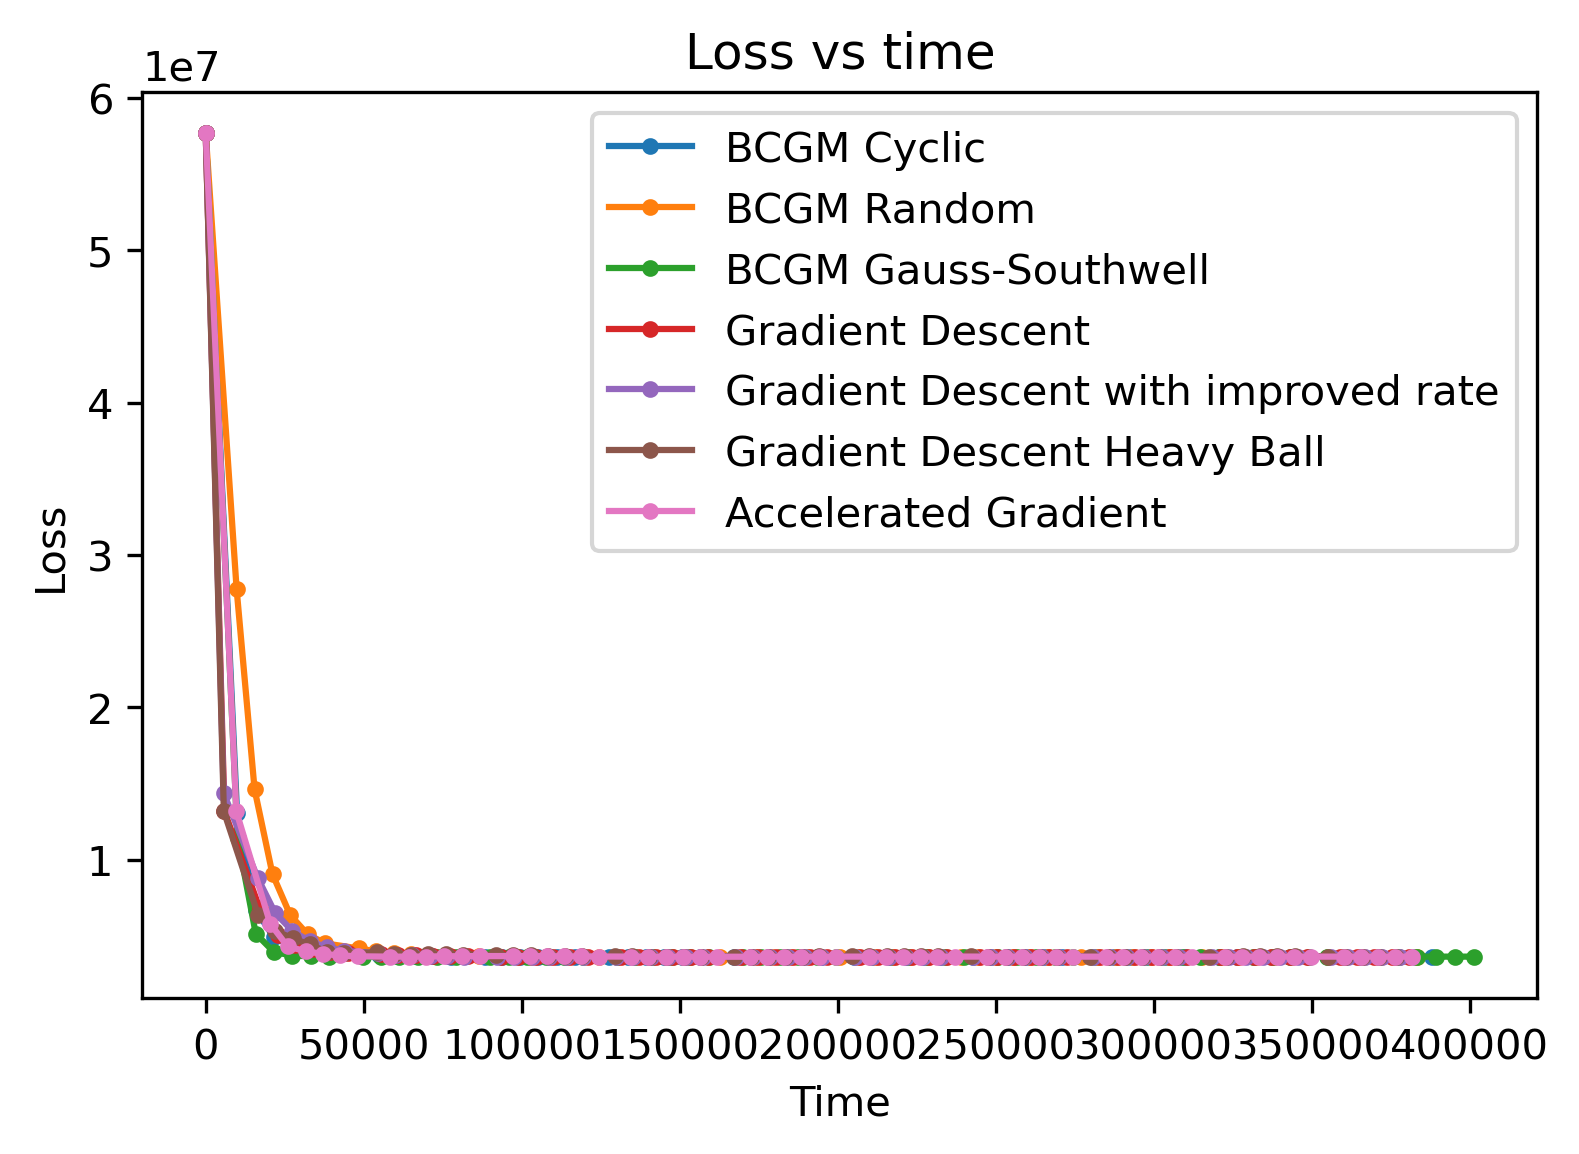

In [975]:
pl.figure(dpi=PLOT_DPI*3)
pl.plot(ticks_bcgd_cyclic , losses_bcgm_cyclic, marker='.')
pl.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
pl.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
pl.plot(ticks_gd , losses_gd, marker='.')
pl.plot(ticks_gd_improved , losses_gd_improved, marker='.')
pl.plot(ticks_gd_hb , losses_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

pl.title("Loss vs time")
pl.xlabel("Time")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper right"
)

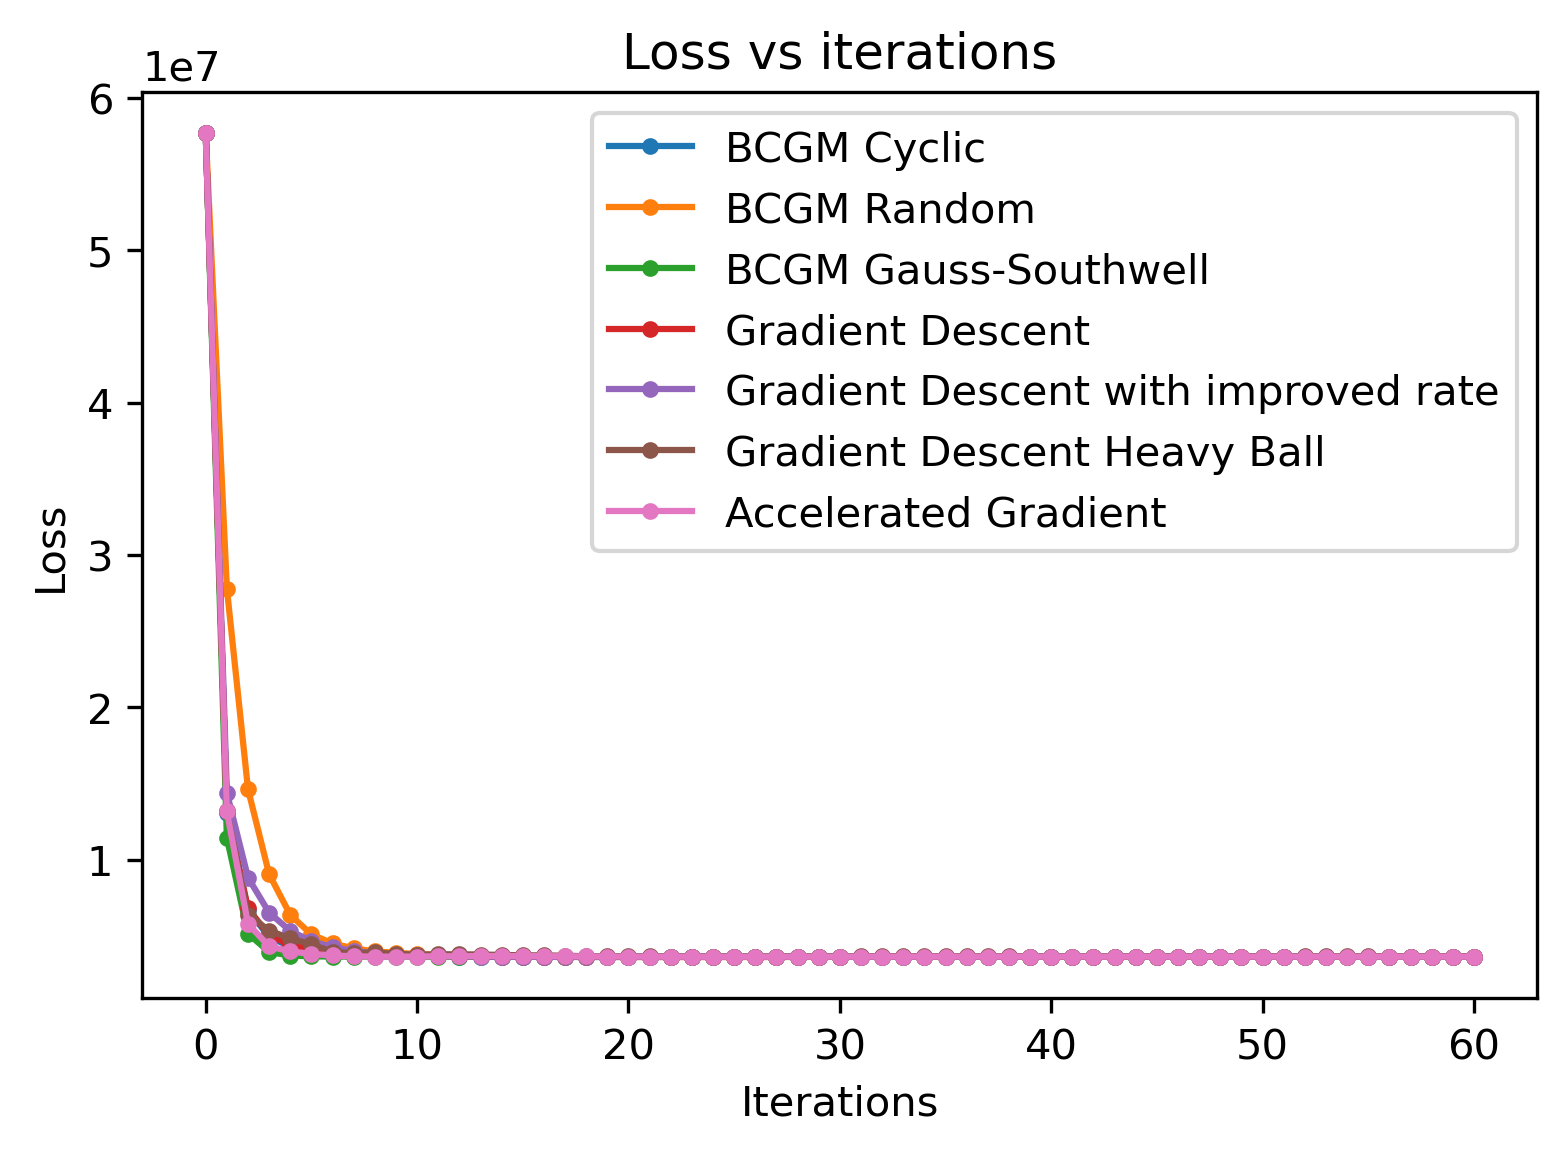

In [976]:
pl.figure(dpi=PLOT_DPI*3)
pl.plot(losses_bcgm_cyclic, marker='.')
pl.plot(losses_bcgm_random, marker='.')
pl.plot(losses_bcgm_gs, marker='.')
pl.plot(losses_gd, marker='.')
pl.plot(losses_gd_improved, marker='.')
pl.plot(losses_gd_hb, marker='.')
pl.plot(losses_gd_accelerated, marker='.')

pl.title("Loss vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper right"
)

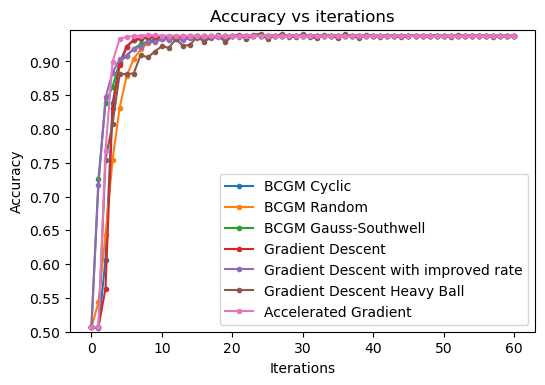

In [977]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(accuracies_bcgd_cyclic, marker='.')
pl.plot(accuracies_bcgd_random, marker='.')
pl.plot(accuracies_bcgd_gs, marker='.')
pl.plot(accuracies_gd, marker='.')
pl.plot(accuracies_gd_improved, marker='.')
pl.plot(accuracies_gd_hb, marker='.')
pl.plot(accuracies_gd_accelerated, marker='.')

pl.title("Accuracy vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Accuracy")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="lower right"
)

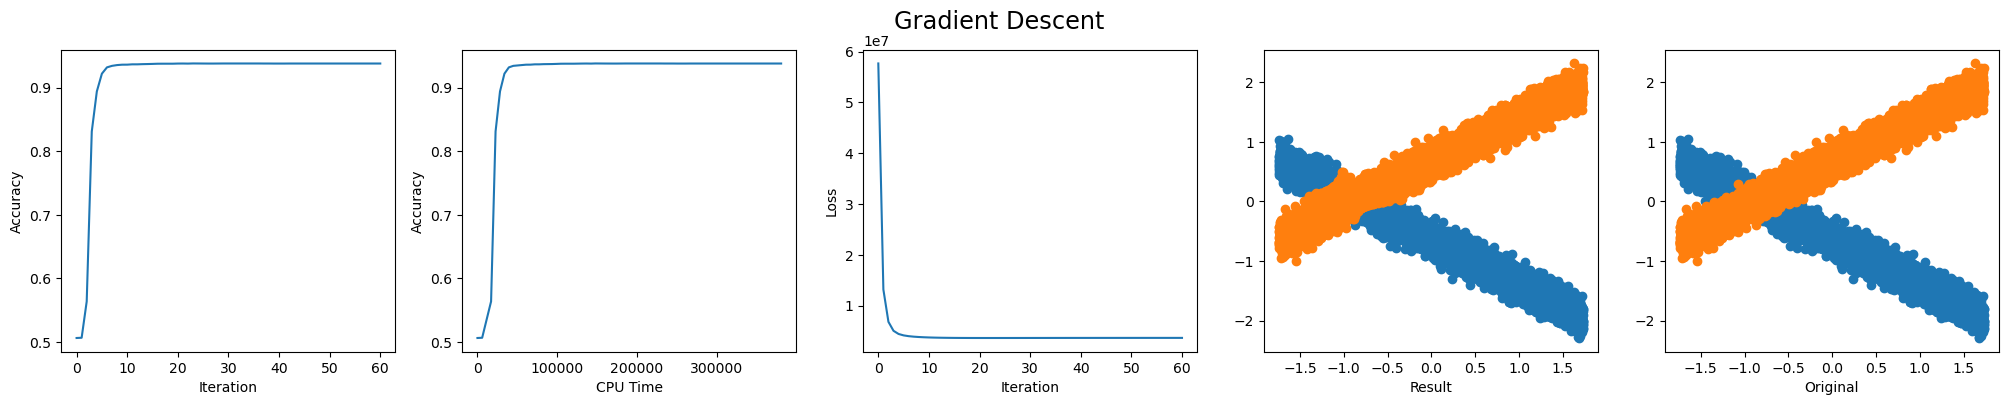

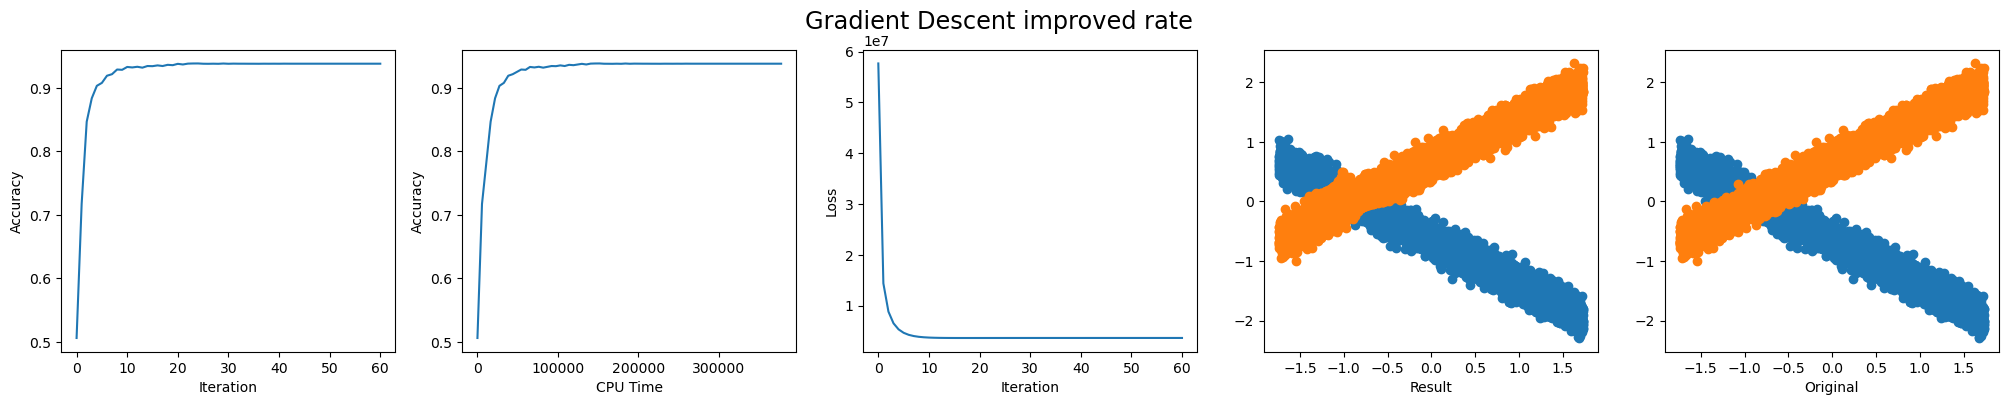

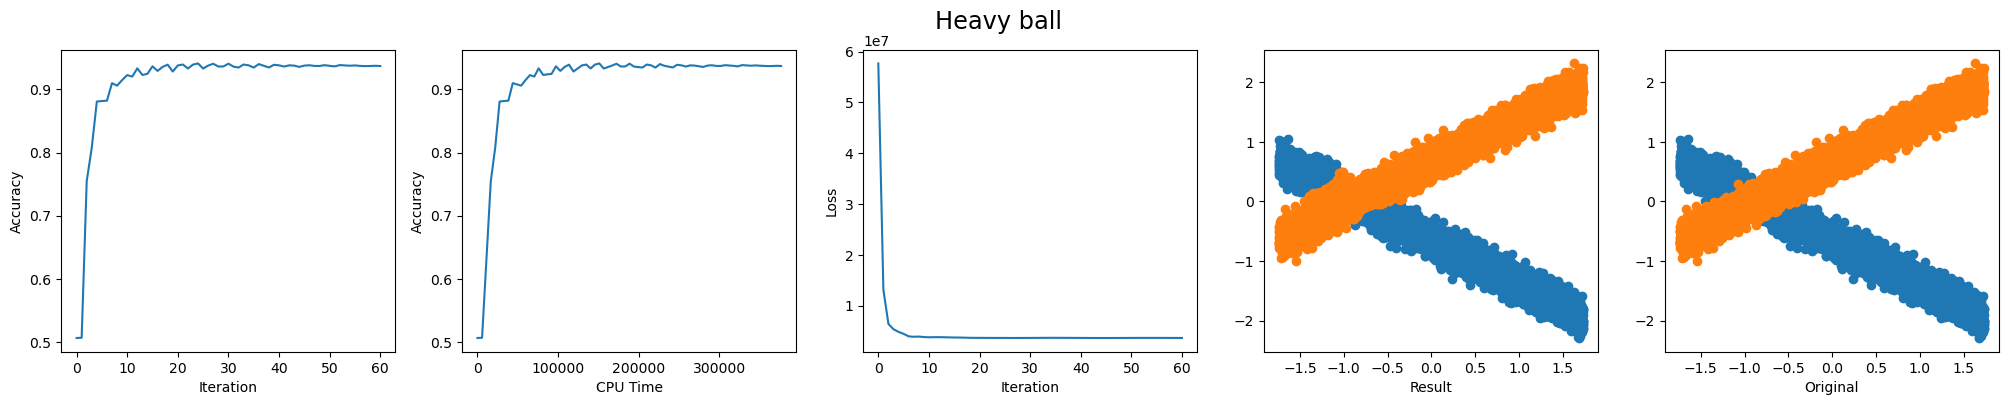

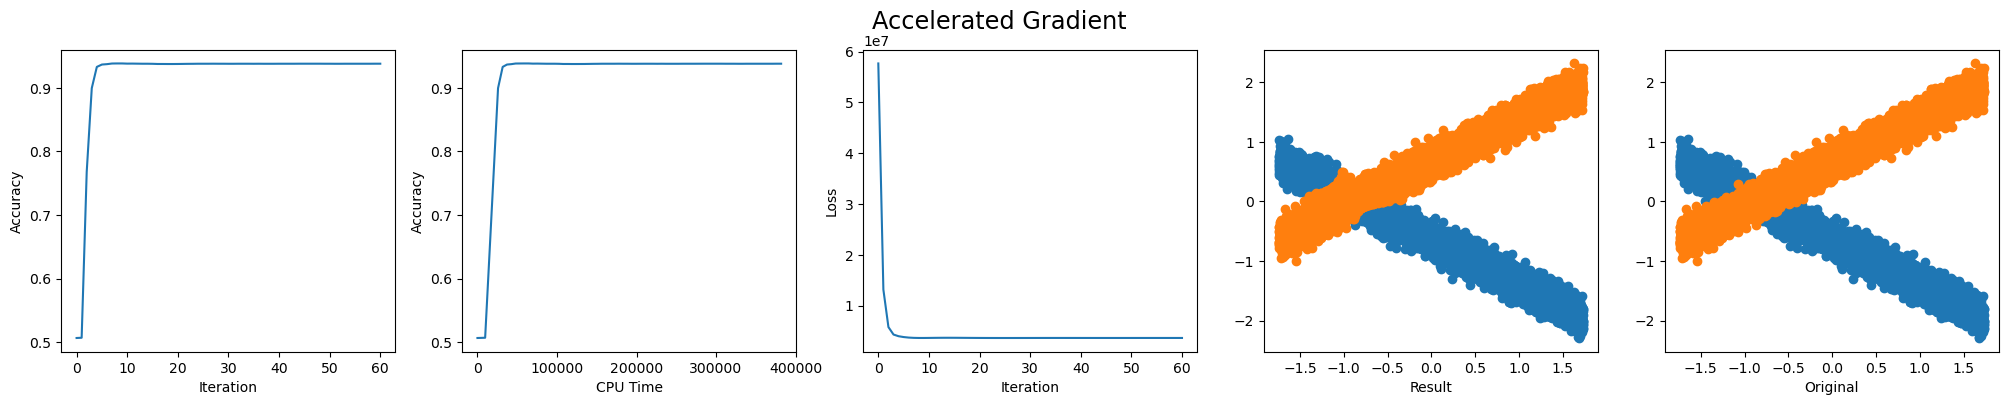

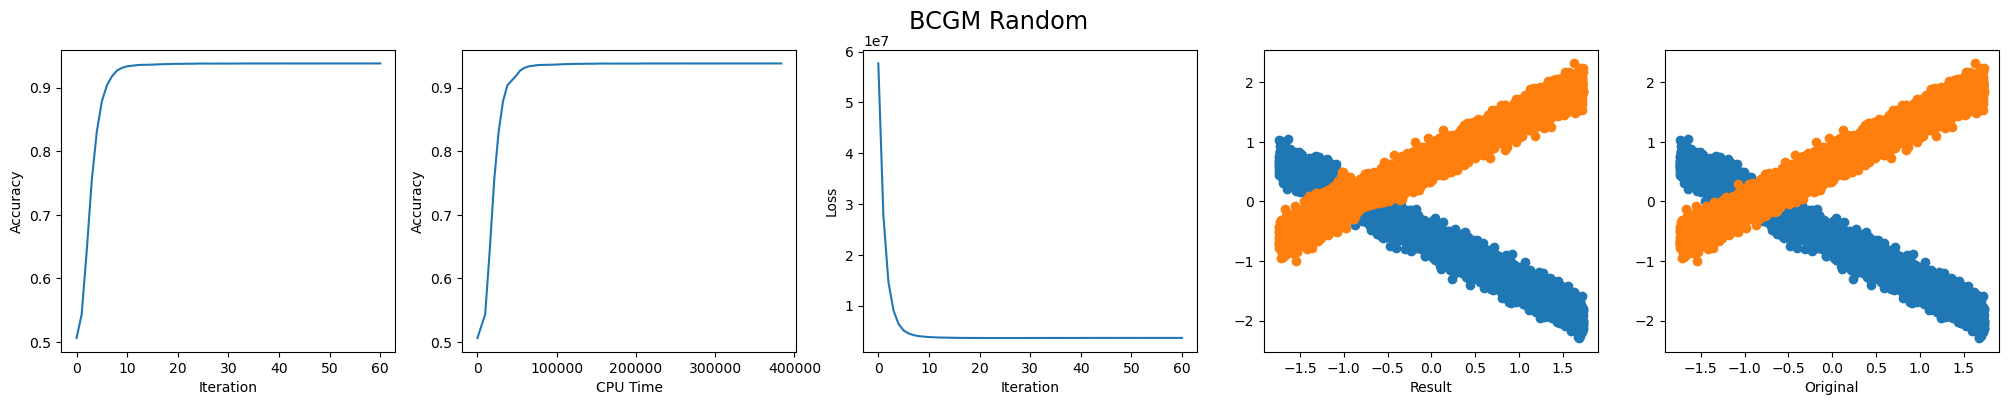

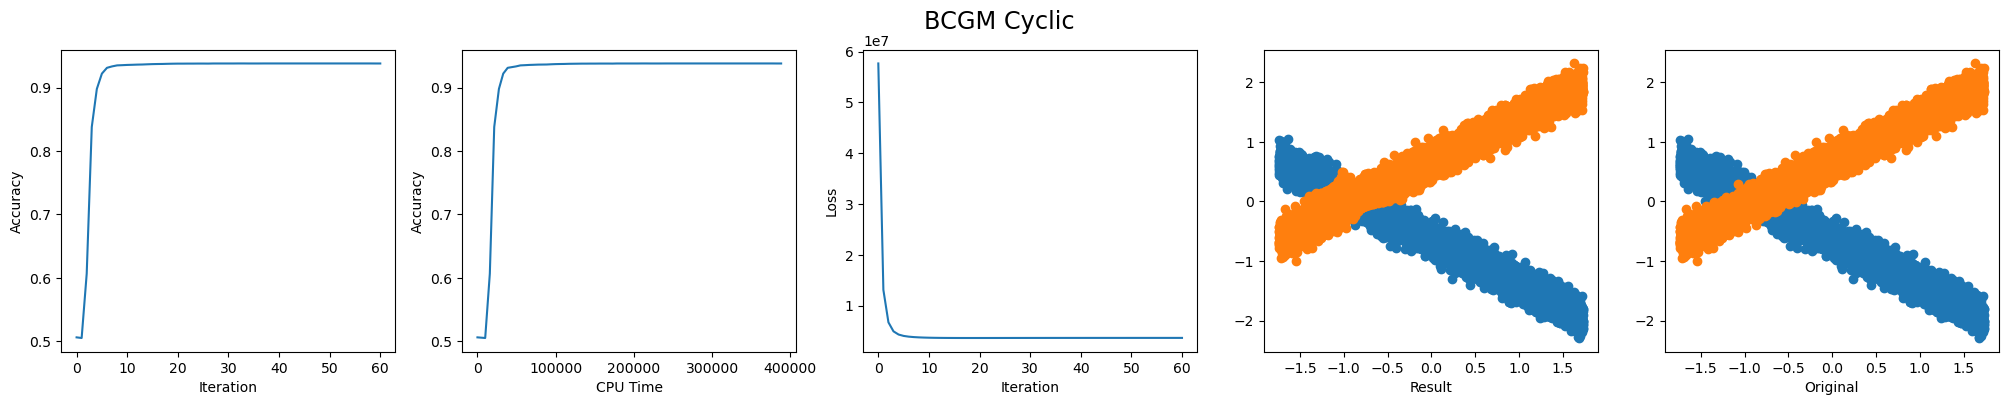

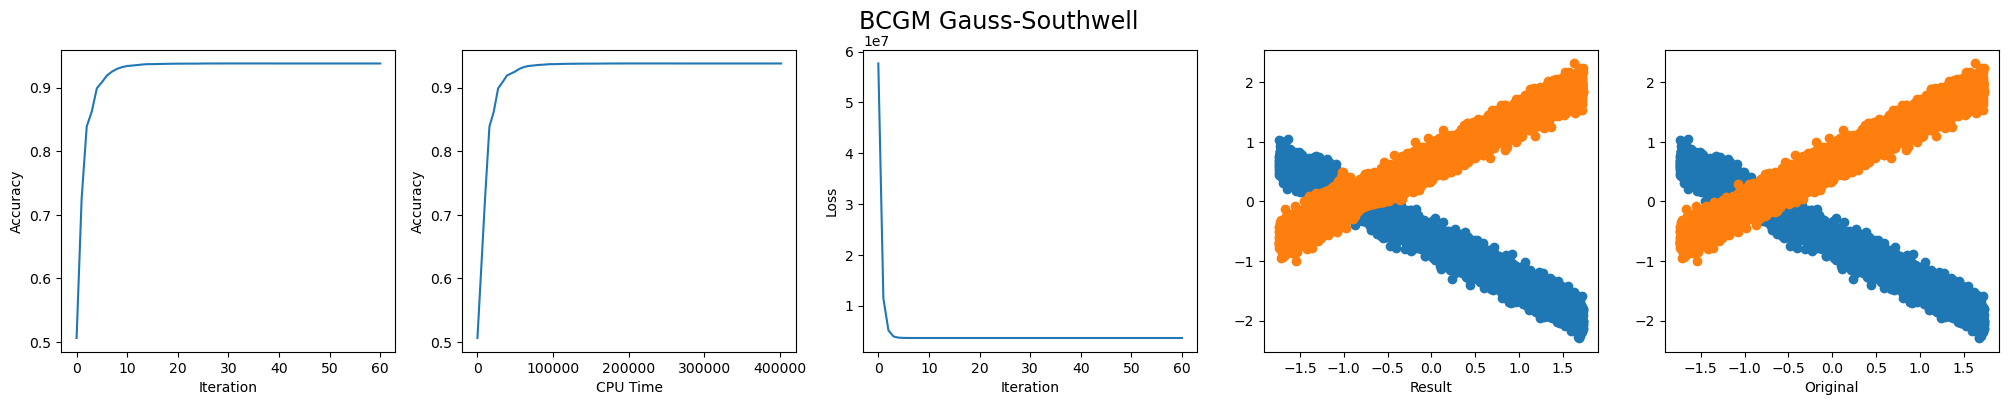

In [978]:
def plots(title, y_unlabeled, ticks, accuracies, losses):
    number_of_subplots = 3 if FROM_DATASET and x_labeled.shape[1] > 2 else 5
    fig, axs = pl.subplots(1 ,number_of_subplots, dpi=PLOT_DPI, figsize=(25, 4))
    fig.suptitle(title, fontsize="xx-large")
    if number_of_subplots > 3:
        axs[3].scatter([p[0] for p in x_unlabeled[y_unlabeled > 0]], [p[1] for p in x_unlabeled[y_unlabeled > 0]])
        axs[3].scatter([p[0] for p in x_unlabeled[y_unlabeled <= 0]], [p[1] for p in x_unlabeled[y_unlabeled <= 0]])
        axs[3].set(xlabel='Result')
        axs[4].set(xlabel='Original')
        axs[4].scatter([p[0] for p in x_unlabeled[y_unlabeled_target == 1]], [p[1] for p in x_unlabeled[y_unlabeled_target == 1]])
        axs[4].scatter([p[0] for p in x_unlabeled[y_unlabeled_target == -1]], [p[1] for p in x_unlabeled[y_unlabeled_target == -1]])
    axs[1].plot(ticks, accuracies)
    axs[1].set(xlabel='CPU Time', ylabel='Accuracy')
    axs[0].plot(accuracies)
    axs[0].set(xlabel='Iteration', ylabel='Accuracy')
    axs[2].plot(losses)
    axs[2].set(xlabel='Iteration', ylabel='Loss')
    pl.show()

for data in [
    ["Gradient Descent", y_unlabeled_gd, ticks_gd, accuracies_gd, losses_gd],
    ["Gradient Descent improved rate", y_unlabeled_gd_improved, ticks_gd_improved, accuracies_gd_improved, losses_gd_improved],
    ["Heavy ball", y_unlabeled_gd_hb, ticks_gd_hb, accuracies_gd_hb, losses_gd_hb],
    ["Accelerated Gradient", y_unlabeled_gd_accelerated, ticks_gd_accelerated, accuracies_gd_accelerated, losses_gd_accelerated],
    ["BCGM Random", y_unlabeled_bcgd_random, ticks_bcgd_random, accuracies_bcgd_random, losses_bcgm_random],
    ["BCGM Cyclic", y_unlabeled_bcgd_cyclic, ticks_bcgd_cyclic, accuracies_bcgd_cyclic, losses_bcgm_cyclic],
    ["BCGM Gauss-Southwell", y_unlabeled_bcgd_gs, ticks_bcgd_gs, accuracies_bcgd_gs, losses_bcgm_gs],
]:
    plots(*data)


### Only BCGM compared

In [979]:
min_acc = np.min(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_bcgd_cyclic, accuracies_bcgd_random, accuracies_bcgd_gs)
    )
)
min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

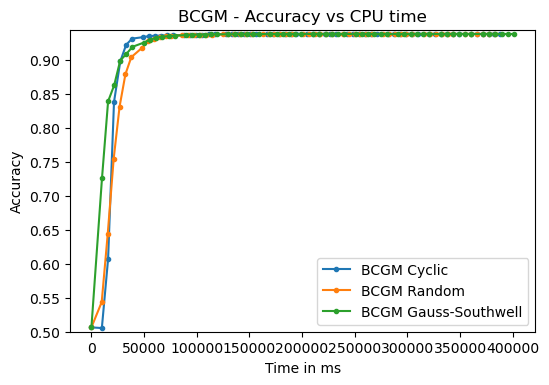

In [980]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')
pl.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')
pl.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

pl.title("BCGM - Accuracy vs CPU time")
pl.xlabel("Time in ms")
pl.ylabel("Accuracy")
pl.legend(
    ['BCGM Cyclic', 'BCGM Random', 'BCGM Gauss-Southwell'],
    loc="lower right"
)

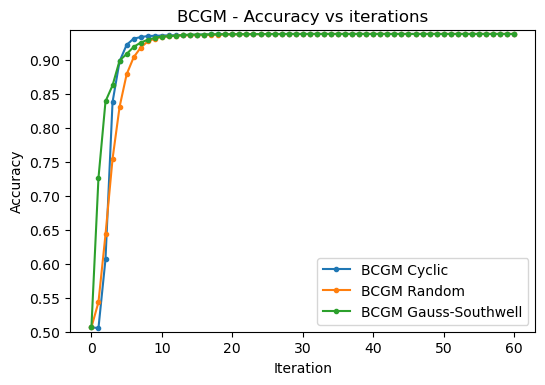

In [981]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(accuracies_bcgd_cyclic, marker='.')
pl.plot(accuracies_bcgd_random, marker='.')
pl.plot(accuracies_bcgd_gs, marker='.')

pl.title("BCGM - Accuracy vs iterations")
pl.xlabel("Iteration")
pl.ylabel("Accuracy")
pl.legend(
    ['BCGM Cyclic', 'BCGM Random', 'BCGM Gauss-Southwell'],
    loc="lower right"
)

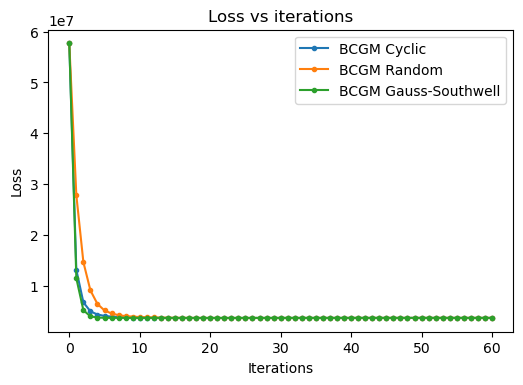

In [982]:
pl.figure(dpi=PLOT_DPI)
pl.plot(losses_bcgm_cyclic, marker='.')
pl.plot(losses_bcgm_random, marker='.')
pl.plot(losses_bcgm_gs, marker='.')

pl.title("Loss vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
    ],
    loc="upper right"
)

### Only Gradient Descent Compared

In [983]:
min_acc = np.min(
    np.concatenate(
        (accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
max_acc = np.max(
    np.concatenate(
        (accuracies_gd, accuracies_gd_hb, accuracies_gd_accelerated, accuracies_gd_improved)
    )
)
min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

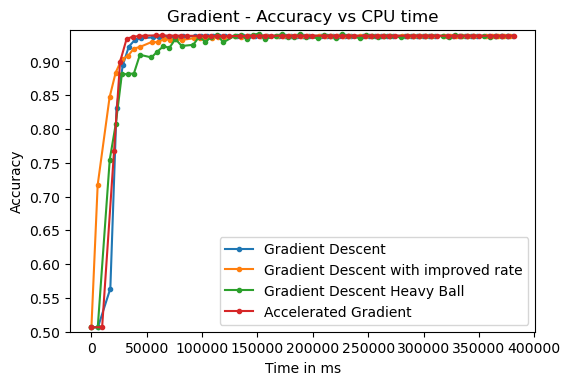

In [984]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(ticks_gd, accuracies_gd, marker='.')
pl.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')
pl.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')
pl.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

pl.title("Gradient - Accuracy vs CPU time")
pl.xlabel("Time in ms")
pl.ylabel("Accuracy")
pl.legend(
    ['Gradient Descent', 'Gradient Descent with improved rate', 'Gradient Descent Heavy Ball', "Accelerated Gradient"],
    loc="lower right"
)

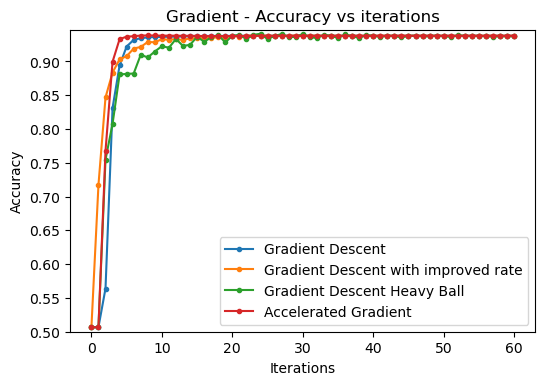

In [985]:
pl.figure(dpi=PLOT_DPI)
pl.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
pl.ylim(min_y_plot, max_y_plot)
pl.plot(accuracies_gd, marker='.')
pl.plot(accuracies_gd_improved, marker='.')
pl.plot(accuracies_gd_hb, marker='.')
pl.plot(accuracies_gd_accelerated, marker='.')

pl.title("Gradient - Accuracy vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Accuracy")

pl.legend(
    ['Gradient Descent', 'Gradient Descent with improved rate', 'Gradient Descent Heavy Ball', "Accelerated Gradient"],
    loc="lower right"
)

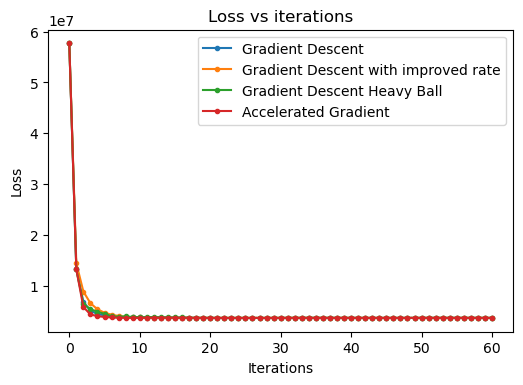

In [986]:
pl.figure(dpi=PLOT_DPI)
pl.plot(losses_gd, marker='.')
pl.plot(losses_gd_improved, marker='.')
pl.plot(losses_gd_hb, marker='.')
pl.plot(losses_gd_accelerated, marker='.')

pl.title("Loss vs iterations")
pl.xlabel("Iterations")
pl.ylabel("Loss")
pl.legend(
    [
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper right"
)

## GIF

In [988]:
if CREATE_GIF:
    paths =[
        "./gif/gd",
        "./gif/gd_improved",
        "./gif/gd_hb",
        "./gif/gd_accelerated",
        "./gif/bcgd_random",
        "./gif/bcgd_cyclic",
        "./gif/bcgd_gs"
    ]
    for i, path in enumerate(paths):
        filenames = sorted([f"{path}/{name}" for name in next(walk(path), (None, None, []))[2]])
        if filenames:
            print(f"creating gif {i+1}/{len(paths)}")
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave(f'{path}.gif', images, duration=30/len(images))
    print("Done")

creating gif 1/7
creating gif 2/7
creating gif 3/7
creating gif 4/7
creating gif 5/7
creating gif 6/7
creating gif 7/7
Done
